In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from src.ai.architectures import *
from src.ai.base_net import ArchitectureConfig
from src.data.utils import create_random_gradient_image

In [42]:
checkpoint = torch.load(f"{os.environ['DATADIR']}/line_segmentation_network/torch_checkpoints/checkpoint_best.ckpt")
output_path = f'{os.environ["DATADIR"]}/debug_line_segmentation_network'
os.makedirs(output_path, exist_ok=True)
network = auto_encoder_deeply_supervised_with_discriminator.Net(
    ArchitectureConfig().create(config_dict={'output_path': output_path,
                                             'architecture': 'auto_encoder_deeply_supervised_with_discriminator'}))
network.load_checkpoint(checkpoint['net_ckpt'])

def plot(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    plt.clf()

def evaluate_binary_mask(mask):
    # create bg image
    bg = np.ones((*network.input_size[1:], 1), np.float32)
    # create fg image
    fg = create_random_gradient_image(bg.shape)
    # combine fg and bg with binary map
    new_img = ((1 - mask) * bg + mask * fg)
    plot(new_img)
    output = network(torch.as_tensor(new_img).permute(2, 0, 1).unsqueeze(0), train=False).permute(1,2,0)
    plot(output)

auto_encoder_deeply_supervised_with_discriminator - INFO - Started.


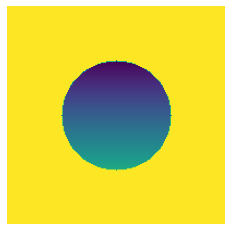

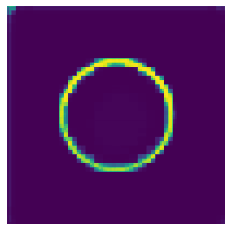

<Figure size 432x288 with 0 Axes>

In [44]:
# Circle
mask = np.zeros((*network.input_size[1:], 1), np.float32)
cv2.circle(mask,(network.input_size[1]//2, network.input_size[1]//2), 
           50, (1), -1)
evaluate_binary_mask(mask)

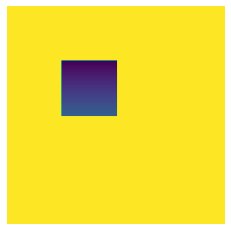

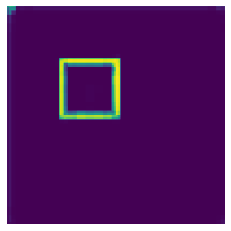

<Figure size 432x288 with 0 Axes>

In [45]:
# Square
mask = np.zeros((*network.input_size[1:], 1), np.float32)
cv2.rectangle(mask,(network.input_size[1]//4, network.input_size[1]//4),
              (network.input_size[1]//2, network.input_size[1]//2), (1), -1)
evaluate_binary_mask(mask)

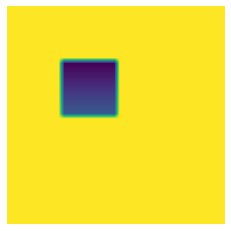

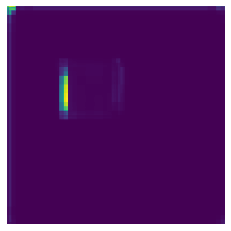

<Figure size 432x288 with 0 Axes>

In [47]:
# Smoothen edges of mask
mask = np.zeros((*network.input_size[1:], 1), np.float32)
cv2.rectangle(mask,(network.input_size[1]//4, network.input_size[1]//4),
              (network.input_size[1]//2, network.input_size[1]//2), (1), -1)
kernel = 5
padding = np.floor((kernel - 1) / 2).astype(np.int32)  # make padding to have same dimensions
mask = torch.nn.AvgPool2d(kernel_size=kernel, stride=1, padding=padding)(torch.as_tensor(mask).permute(2, 0, 1).unsqueeze(0)).squeeze(0).permute(1, 2, 0)
evaluate_binary_mask(mask)

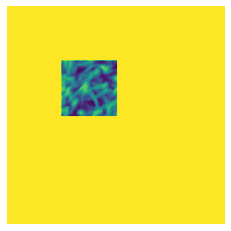

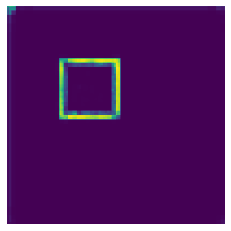

<Figure size 432x288 with 0 Axes>

In [49]:
from src.data.utils import load_and_preprocess_file
# Textured foreground with strong edges
mask = np.zeros((*network.input_size[1:], 1), np.float32)
cv2.rectangle(mask,(network.input_size[1]//4, network.input_size[1]//4),
              (network.input_size[1]//2, network.input_size[1]//2), (1), -1)

# create bg image
bg = np.ones((*network.input_size[1:], 1), np.float32)
# create fg image
fg = load_and_preprocess_file(f'{os.environ["DATADIR"]}/textured_dataset/Kyberge_rug1/5.jpg',
                              size=(1, bg.shape[0], bg.shape[1])).permute(1, 2, 0).numpy()

# combine fg and bg with binary map
new_img = ((1 - mask) * bg + mask * fg)
plot(new_img)
output = network(torch.as_tensor(new_img).permute(2, 0, 1).unsqueeze(0), train=False).permute(1,2,0)
plot(output)